In [9]:
import sys

sys.path.append('../')
sys.path.append('../my_libs/')
sys.path.append('../my_libs/img/')

!{sys.executable} -m pip install -r ../../pip-dependencies.txt

error: externally-managed-environment

× This environment is externally managed
╰─> To install Python packages system-wide, try apt install
    python3-xyz, where xyz is the package you are trying to
    install.
    
    If you wish to install a non-Debian-packaged Python package,
    create a virtual environment using python3 -m venv path/to/venv.
    Then use path/to/venv/bin/python and path/to/venv/bin/pip. Make
    sure you have python3-full installed.
    
    If you wish to install a non-Debian packaged Python application,
    it may be easiest to use pipx install xyz, which will manage a
    virtual environment for you. Make sure you have pipx installed.
    
    See /usr/share/doc/python3.12/README.venv for more information.

note: If you believe this is a mistake, please contact your Python installation or OS distribution provider. You can override this, at the risk of breaking your Python installation or OS, by passing --break-system-packages.
hint: See PEP 668 for the detai

In [10]:
from my_libs.tools import *
from my_libs.colors import *

## Cvičení

Natrénujte a vyhodnoťte klasifikátor založený na hluboké neuronové síti, který 
bude  z  obrázku  člověka  určovat,  zda  se  jedná  o  dospělého  či  o  dítě.  Pro 
trénování a validaci využijte dataset children-vs-adults.zip. Klasifikátor by měl 
dosáhnout přesnosti (accuracy) alespoň 80 % na validační množině. 

### Poznámky
Není to nezbytné, ale běh na GPU bude rychlejší než na CPU. Kód lze spustit na zdarma dostupných službách poskytujících GPU, např.: 
- [Google colab](https://colab.research.google.com/drive/16pBJQePbqkz3QFV54L4NIkOn1kwpuRrj) 

Můžete  použít  libovolnou  dostupnou  knihovnu  pro  práci  s  neuronovými sítěmi.  Doporučené  jsou PyTorch nebo Keras, které  jsou  dobře dokumentované se spoustou příkladů. 

Doporučený postup je tzv. transfer learning, tj. použití existujícího modelu a  jeho  přizpůsobení  na  novou  úlohu.  Příklady  transfer  learningu  jsou dostupné na Transfer learning v:
- [Pytorch](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)
- [Keras](https://keras.io/guides/transfer_learning/)

Předtrénované  neuronové  sítě  pro  klasifikaci  obrázků  lze  vybírat  z  tzv. 
ZOO modelů. 
Knihovna modelů a datasetů:
- [torchvision](https://pytorch.org/vision/stable/index.html)
- [Pytorch timm](https://huggingface.co/docs/timm/quickstart)
- [Keras](https://keras.io/api/applications/)

Není nezbytné používat veké modely. Požadovaného skóre lze dosáhnout i s menšími  modely. Např.  předtrénovaný model  „resnet10t”  z  knihovny timm (PyTorch) dosahuje 80% přesnosti  již  po  `3`  epochách při `batch_size=100`  a  optimalizačním algoritmu  Adam  s  `learning_rate = 0.001`. 
Jedna epocha na CPU Ryzen 7 5700X trvá cca 21 s.

## Uvažované modely
Stažené z [Hugging Face](https://huggingface.co/models?pipeline_tag=image-classification&sort=trending&search=Microsoft+resnet)

Z dílny Microsoftu:
- [resnet-18](https://huggingface.co/microsoft/resnet-18)
- [resnet-50](https://huggingface.co/microsoft/resnet-50)
- [resnet-152](https://huggingface.co/microsoft/resnet-152)

### Výběr modelu a jeho modifikace

In [11]:
from transformers import AutoImageProcessor, AutoModelForImageClassification
import os
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

In [12]:
# Načtení modelu a procesoru
image_processor = AutoImageProcessor.from_pretrained("microsoft/resnet-18")
model = AutoModelForImageClassification.from_pretrained("microsoft/resnet-18")

# Nastavení modelu pro transfer learning
if isinstance(model.classifier, torch.nn.Sequential):
    in_features = model.classifier[-1].in_features
    model.classifier[-1] = torch.nn.Linear(in_features, 2)  # Binary classification (adult/children)
else:
    in_features = model.classifier.in_features
    model.classifier = torch.nn.Linear(in_features, 2)  # Binary classification (adult/children)


### Hyper parametry

In [13]:
# parametry
batch_size = 100
learning_rate = 1e-4
num_epochs = 10

## Data set

In [14]:
number_of_pictures = 800
folder = "children_vs_adults"
train_folder = "train"
test_folder = "valid"
pwd = os.getcwd()

# Cesty k trénovacím a testovacím složkám
#long_path = os.path.join(pwd, folder)
long_path = folder
train_path = os.path.join(long_path, train_folder)
test_path = os.path.join(long_path, test_folder)

print("Assembling directory paths...")
print("Current working directory: ", pwd)

# test if the folder exists
paths = [train_path, test_path]
for path in paths:
    if not os.path.exists(path):
        raise Exception("Folder does not exist: " + path)

print("Train path: ", Blue + train_path + NC)
print("Test path: ", Blue + test_path + NC)

Assembling directory paths...
Current working directory:  /home/vojta/PVI-Pocitacove_videni/cviceni/cv12
Train path:  children_vs_adults/train
Test path:  children_vs_adults/valid


In [15]:
# Nastavení transformací pro dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
])

# Načtení datasetu
print("Loading the dataset...")

# Načtení datasetu
train_dataset = datasets.ImageFolder(train_path, transform=transform)
test_dataset = datasets.ImageFolder(test_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("Number of training examples: ", Blue + str(len(train_dataset)) + NC)
print("Number of test examples: ", Blue + str(len(test_dataset)) + NC)

print("")
if len(train_dataset) + len(test_dataset) != number_of_pictures:
    print("Number of pictures in the dataset is not correct.")
    print("Expected number of pictures: ", number_of_pictures)
    print("Number of pictures in the dataset: ", len(train_dataset) + len(test_dataset))
    exit(1)
else:
    print(Green + "Dataset loaded successfully." + NC)


Loading the dataset...
Number of training examples:  680
Number of test examples:  120

Dataset loaded successfully.


## Transfer learning

### Nastavení trénování

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

print("Hyper parameters:")
print("Batch size: \t", Blue + str(batch_size) + NC)
print("Learning rate: \t", Blue + str(learning_rate) + NC)
print("Usig device: \t", Blue + str(device) + NC)

Hyper parameters:
Batch size: 	 100
Learning rate: 	 0.0001
Usig device: 	 cpu


### Trénování modelu

In [17]:
losses = []
accuracies = []
for epoch in range(num_epochs):
    # Trenovani modelu
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    losses.append(running_loss/len(train_loader))
    
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

    # Testovani modelu
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    accuracies.append(accuracy)

    print(f"Accuracy of the model: {100 * accuracy:.2f}%")

print("Training finished.")
print("Final accuracy of the model on the test images: ", Green + str(accuracy) + NC)

Epoch [1/10], Loss: 0.5930
Accuracy of the model: 78.33%
Epoch [2/10], Loss: 0.1745
Accuracy of the model: 78.33%
Epoch [3/10], Loss: 0.0579
Accuracy of the model: 78.33%
Epoch [4/10], Loss: 0.0193
Accuracy of the model: 83.33%
Epoch [5/10], Loss: 0.0075
Accuracy of the model: 83.33%
Epoch [6/10], Loss: 0.0037
Accuracy of the model: 82.50%
Epoch [7/10], Loss: 0.0027
Accuracy of the model: 80.83%
Epoch [8/10], Loss: 0.0020
Accuracy of the model: 80.83%
Epoch [9/10], Loss: 0.0018
Accuracy of the model: 80.83%
Epoch [10/10], Loss: 0.0013
Accuracy of the model: 81.67%
Training finished.
Final accuracy of the model on the test images:  0.8166666666666667


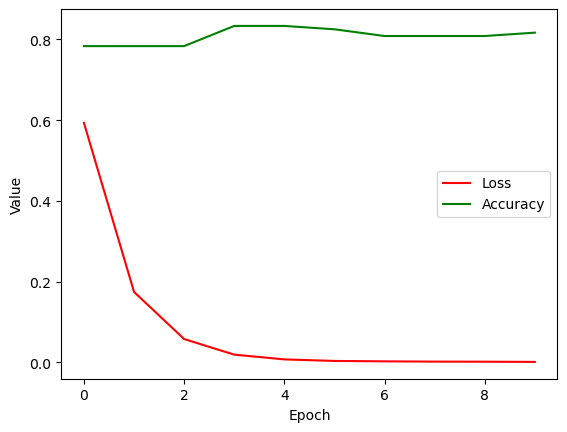

In [18]:
# plot loss R, accuracy G
plt.figure()
plt.plot(losses, 'r')
plt.plot(accuracies, 'g')
plt.xlabel("Epoch")
plt.ylabel("Value")
plt.legend(["Loss", "Accuracy"])
plt.show()